## **1. Google Drive**

In [159]:
#from google.colab import drive
#drive.mount('/content/drive')
#cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
#%cd $cur_dir


In [160]:
#%pip install torchview


In [161]:
LOCAL = False


## **2. Import Libraries**

In [162]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'


# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu128
Device: cuda


## **3. Config**

In [163]:
USE_MASKED_PATCHES = False

In [164]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")

MASKS_DIR = os.path.join(datasets_path, "preprocessing_results", "train_patches", "masks")
print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")
  

# ImageNet normalization statistics
IMAGENET_MEAN = [float(x) for x in [0.485, 0.456, 0.406]]  # or convert your current values to float
IMAGENET_STD  = [float(x) for x in [0.229, 0.224, 0.225]]

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches


In [165]:
# Create a simple function to handle this
def print_model_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")

In [166]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """Plot all patches of a single sample and the aggregated image prediction (Two-Stream Model)."""
    model.eval()
    
    # 1. Robust Dataset Access
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'): # Unwrap Subsets
        dataset = dataset.dataset
    df = dataset.df
    masks_dir = getattr(dataset, 'masks_location', None)

    # 2. Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # 3. Define Transforms
    # Image: Resize -> ToTensor -> Normalize
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Mask: Resize -> ToTensor (No Normalize)
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # 4. Load Data
    images_tensors = []
    masks_tensors = []
    display_imgs = []
    
    # Stats for denormalization (Display only)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    for _, row in sample_patches.iterrows():
        try:
            # --- A. Image ---
            img_path = row['path']
            img = Image.open(img_path).convert('RGB')
            tensor_img = inference_transform(img)
            images_tensors.append(tensor_img)
            
            # Display image (Denormalize)
            disp_img = torch.clamp(tensor_img * std + mean, 0, 1)
            display_imgs.append(disp_img)
            
            # --- B. Mask ---
            if masks_dir:
                img_filename = os.path.basename(img_path)
                mask_filename = img_filename.replace('img_', 'mask_')
                mask_path = os.path.join(masks_dir, mask_filename)
                
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert('L')
                else:
                    mask = Image.new('L', (224, 224), 0)
            else:
                 mask = Image.new('L', (224, 224), 0)
            
            tensor_mask = mask_transform(mask)
            masks_tensors.append(tensor_mask)

        except Exception as e:
            print(f"Error loading {row['path']}: {e}")
            continue

    if not images_tensors:
        print("No valid images found for this sample.")
        return

    # 5. Batch Inference
    batch_imgs = torch.stack(images_tensors).to(device)
    batch_masks = torch.stack(masks_tensors).to(device)
    
    with torch.no_grad():
        # --- FIX: Pass BOTH pillars ---
        # Model returns ONLY logits for Two-Stream
        logits = model(batch_imgs, batch_masks) 
        probs = torch.softmax(logits, dim=1).cpu()

    # 6. Process Predictions
    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    # --- Aggregation Logic ---
    if aggregation_method == 'max_confidence':
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    # Labels
    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label_idx = sample_patches.iloc[0]['label_encoded']
    true_label = label_encoder.inverse_transform([true_label_idx])[0]

    # 7. Plotting
    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        
        lbl = label_encoder.inverse_transform([pred])[0]
        color = 'green' if pred == image_pred else 'red'
        
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9, color='black', backgroundcolor='white')
        ax.axis('off')

    # Aggregated Bar Chart
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'lightgray' for i in range(len(class_names))]
    
    y_pos = np.arange(len(class_names))
    ax_bar.barh(y_pos, image_probs, color=colors)
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(class_names)
    ax_bar.invert_yaxis()
    
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label}\nPred: {image_pred_label} ({image_conf:.2%})\n{aggregation_method}")
    
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')

    plt.tight_layout()
    plt.show()

In [167]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level for Two-Stream (Pillar) models.
    """
    model.eval()

    # 1. robustly retrieve the underlying dataset (handles torch.utils.data.Subset)
    dataset = loader.dataset
    while hasattr(dataset, 'dataset'):
        dataset = dataset.dataset
        
    df = dataset.df
    
    # Retrieve the specific mask folder from the dataset logic
    # This ensures we look in '.../masks/' regardless of where images are
    masks_dir = getattr(dataset, 'masks_location', None)
    print(f"\nUsing masks from: {masks_dir if masks_dir else 'No masks directory specified, using black masks.'}")
    # 2. Define Transforms
    # Image: Standard normalization
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Mask: Resize + ToTensor only
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    y_true = []
    y_pred = []
    
    sample_ids = df['sample_id'].unique()
    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches for this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)

        patches_img = []
        patches_mask = []

        for img_path in sample_patches['path']:
            try:
                # --- A. Load Image ---
                img = Image.open(img_path).convert('RGB')
                img = inference_transform(img)
                
                # --- B. Load Mask (Robust Path Construction) ---
                if masks_dir:
                    # Logic: /path/to/masks/ + mask_filename.png
                    img_filename = os.path.basename(img_path)
                    mask_filename = img_filename.replace('img_', 'mask_')
                    mask_path = os.path.join(masks_dir, mask_filename)
                    
                    if os.path.exists(mask_path):
                        mask = Image.open(mask_path).convert('L')
                    else:
                        # Fallback: Create black mask if file missing
                        mask = Image.new('L', (224, 224), 0)
                else:
                    # Fallback: No mask directory known -> Black mask
                    mask = Image.new('L', (224, 224), 0)
                
                mask = mask_transform(mask)
                
                patches_img.append(img)
                patches_mask.append(mask)

            except Exception as e:
                continue

        if not patches_img:
            y_pred.append(true_label) # Fallback
            continue

        # Stack batch
        batch_imgs = torch.stack(patches_img).to(device)
        batch_masks = torch.stack(patches_mask).to(device)

        with torch.no_grad():
            # --- Pass BOTH Image and Mask Pillars ---
            logits = model(batch_imgs, batch_masks)
            
            # Softmax to get probabilities
            probs = torch.softmax(logits, dim=1)

            # Average pooling of probabilities
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred

## **4. Train/Val Split**

In [168]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [169]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 3097 patches. Parsing metadata...
Successfully created DataFrame with 3097 rows.

First 5 rows:
          filename      label sample_id
0  img_0690_p2.png  Luminal A  img_0690
1  img_0690_p1.png  Luminal A  img_0690
2  img_0690_p0.png  Luminal A  img_0690
3  img_0689_p3.png  Luminal A  img_0689
4  img_0689_p2.png  Luminal A  img_0689

Patches per Bag (Distribution):
count    631.000000
mean       4.908082
std        2.913207
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [170]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [171]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2445
Val patches: 652

Train label distribution:
label
Luminal B          852
Luminal A          684
HER2(+)            676
Triple negative    233
Name: count, dtype: int64

Val label distribution:
label
Luminal B          238
HER2(+)            160
Luminal A          159
Triple negative     95
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.846626
Luminal A          27.975460
HER2(+)            27.648262
Triple negative     9.529652
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          36.503067
HER2(+)            24.539877
Luminal A          24.386503
Triple negative    14.570552
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [172]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.3,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

## **6. Custom Dataset Class**

In [173]:
import torch
import torchvision.transforms.functional as TF
import random
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class TissueDataset(Dataset):
    def __init__(self, df, img_dir=None, masks_dir=None, augmentation=None, normalize_imagenet=True, target_size=(224, 224), label_col='label_encoded'):
        """
        Args:
            df: DataFrame containing metadata.
            img_dir: Root directory for images.
            masks_dir: (Backwards compat) Root directory.
            augmentation: Augmentation pipeline.
            normalize_imagenet: Boolean to apply ImageNet norm.
            target_size: Tuple (H, W).
            label_col: Column name containing the Integer labels.
        """
        self.df = df
        
        # --- Handle Directory Logic ---
        root_dir = img_dir if img_dir is not None else masks_dir
        
        # Look for masks in root/masks/
        if root_dir:
            self.masks_location = os.path.join(root_dir, 'masks')
        else:
            self.masks_location = None

        self.do_augmentation = augmentation is not None 
        self.normalize_imagenet = normalize_imagenet
        self.target_size = target_size
        self.label_col = label_col

        # 1. Standard Normalization
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        
        # 2. Image-Only Augmentations
        self.color_jitter = transforms.ColorJitter(
            brightness=0.0, contrast=0.2, saturation=0.0, hue=0.1
        )
        
        # 3. Random Erasing
        self.random_erasing = transforms.RandomErasing(
            p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- A. Load Image ---
        img_path = row['path']
        image = Image.open(img_path).convert("RGB")
        
        # --- B. Load Mask (Handle Naming Difference) ---
        if self.masks_location:
            # 1. Get image filename (e.g., 'img_1234_p5.png')
            img_filename = os.path.basename(img_path)
            
            # 2. Convert to mask filename (e.g., 'mask_1234_p5.png')
            # This is the critical fix for your naming convention
            mask_filename = img_filename.replace('img_', 'mask_')
            
            mask_path = os.path.join(self.masks_location, mask_filename)
            
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert("L") 
            else:
                # Debugging tip: Print this if your masks are all black/empty to verify path
                # print(f"Missing mask: {mask_path}") 
                mask = Image.new('L', image.size, 0)
        else:
            mask = Image.new('L', image.size, 0)

        # --- C. Resize ---
        image = TF.resize(image, self.target_size)
        mask = TF.resize(mask, self.target_size, interpolation=transforms.InterpolationMode.NEAREST)

        # --- D. SYNCHRONIZED AUGMENTATION ---
        if self.do_augmentation:
            if random.random() > 0.5: # Flip
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            angle = transforms.RandomRotation.get_params(degrees=[-15, 15]) # Rotate
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

            # Affine
            ret_angle, translations, scale, shear = transforms.RandomAffine.get_params(
                degrees=[0, 0], translate=(0.1, 0.1), scale_ranges=None, shears=[-10, 10], img_size=image.size
            )
            image = TF.affine(image, angle=ret_angle, translate=translations, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=ret_angle, translate=translations, scale=scale, shear=shear)

            image = self.color_jitter(image) # Color Jitter (Image Only)

        # --- E. Convert to Tensor ---
        img_tensor = TF.to_tensor(image)
        mask_tensor = TF.to_tensor(mask)

        ## --- F. Random Erasing (Image Tensor Only) ---
        #if self.do_augmentation:
        #    img_tensor = self.random_erasing(img_tensor)

        # --- G. Final Prep ---
        mask_tensor = (mask_tensor > 0.5).float()
        
        if self.normalize_imagenet:
            img_tensor = self.normalize(img_tensor)

        # --- H. Return Label ---
        label = torch.tensor(row[self.label_col], dtype=torch.long)
        
        return img_tensor, label, mask_tensor

## **7. Data Loaders**

In [174]:
if LOCAL: 
    num_workers = 0
    CACHE_IMAGES = False
else:
    num_workers = os.cpu_count()//2
    CACHE_IMAGES = True

# Instantiate Datasets
train_dataset = TissueDataset(
    df_train, 
    augmentation=train_augmentation, 
    normalize_imagenet=True, 
    img_dir=PATCHES_OUT
)
val_dataset = TissueDataset(
    df_val, 
    augmentation=None, 
    normalize_imagenet=True,
    img_dir=PATCHES_OUT
)

In [175]:


# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64



# Instantiate Loaders with optimizations
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
 # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
# Keep workers alive between epochs
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 39 batches
Val Loader: 11 batches
Num workers: 16



Visualizing Training Batch (Augmented):


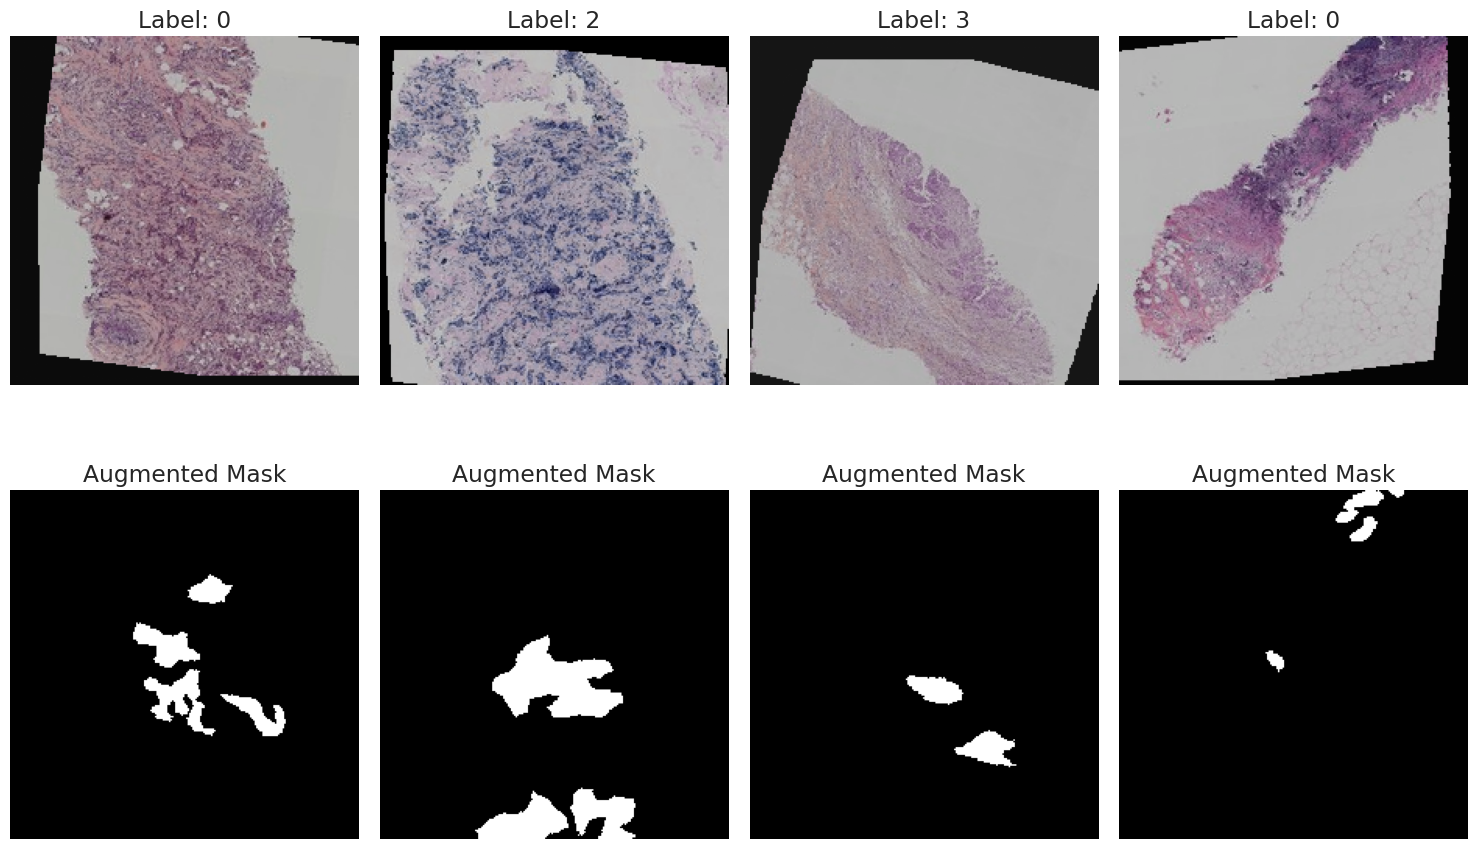

In [176]:
def show_batch(loader, count=4):
    # 1. Robust Unpacking
    # The loader might return 2 items (Image, Label) or 3 (Image, Label, Mask)
    batch = next(iter(loader))
    images, labels = batch[0], batch[1]
    masks = batch[2] if len(batch) > 2 else None

    # Determine layout: 1 row if no masks, 2 rows if masks exist
    nrows = 2 if masks is not None else 1
    plt.figure(figsize=(15, 5 * nrows))

    # Denormalize for visualization (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(count):
        # --- Plot Image ---
        ax = plt.subplot(nrows, count, i + 1)
        
        img = images[i]
        img = img * std + mean  # Un-normalize
        img = torch.clamp(img, 0, 1)  # Clip to valid range
        
        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

        # --- Plot Mask (if available) ---
        if masks is not None:
            ax = plt.subplot(nrows, count, i + 1 + count) # Second row
            mask = masks[i]
            # Mask is (1, H, W), squeeze to (H, W) for matplotlib
            plt.imshow(mask.squeeze(), cmap="gray")
            plt.title("Augmented Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [177]:
DROPOUT_RATE = 0.3
HIDDEN_SIZE = 512
L2_REG = 1e-4

NUM_EPOCHS = 100  # Increased since we have early stopping
PATIENCE = 10   # Stop if val_loss doesn't improve for 5 epochs

## **9. Model Definition (Transfer Learning - MobileNetV3)**

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# IMPORTANT: this is RetCCL's ResNet implementation (copy ResNet.py from the RetCCL repo)
import ResNet as RetCCLResNet


def _clean_state_dict(sd: dict) -> dict:
    """Strip common prefixes (DataParallel, wrapper modules)."""
    out = {}
    for k, v in sd.items():
        for p in ("module.", "model.", "encoder.", "backbone."):
            if k.startswith(p):
                k = k[len(p):]
        out[k] = v
    return out


class MaskedGAP(nn.Module):
    """
    Masked Global Average Pooling.
    feat: [B, C, Hf, Wf]
    mask: [B, 1, H, W] or [B, H, W] (will be resized to Hf x Wf)
    """
    def __init__(self, mode: str = "bilinear", eps: float = 1e-6):
        super().__init__()
        self.mode = mode
        self.eps = eps

    def forward(self, feat: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        if mask.dim() == 3:
            mask = mask.unsqueeze(1)  # [B,1,H,W]
        mask = mask.float()

        # Resize mask to feature map resolution
        mask = F.interpolate(mask, size=feat.shape[-2:], mode=self.mode,
                             align_corners=False if self.mode in ("bilinear", "bicubic") else None)

        # Weighted average over spatial dims
        masked_feat = feat * mask
        denom = mask.sum(dim=(2, 3), keepdim=True).clamp_min(self.eps)
        pooled = masked_feat.sum(dim=(2, 3), keepdim=True) / denom  # [B,C,1,1]
        return pooled.flatten(1)  # [B,C]


class RetCCLResNet50_MGAP(nn.Module):
    def __init__(
        self,
        num_classes: int,
        dropout_rate: float = 0.2,
        freeze_backbone: bool = True,
        ckpt_path: str = "best_ckpt.pth",
        unfreeze_last_block: bool = True,
        mask_pool_mode: str = "nearest",  # use "nearest" if you want strictly-binary masks after resize
    ):
        super().__init__()

        # 1) Build RetCCL ResNet50
        self.backbone = RetCCLResNet.resnet50(
            num_classes=128, mlp=False, two_branch=False, normlinear=True
        )

        # 2) Load RetCCL pretrained weights (drop fc.*)
        sd = torch.load(ckpt_path, map_location="cpu")
        if isinstance(sd, dict) and "state_dict" in sd:
            sd = sd["state_dict"]
        sd = _clean_state_dict(sd)
        sd = {k: v for k, v in sd.items() if not k.startswith("fc.")}
        self.backbone.load_state_dict(sd, strict=False)

        # 3) We will NOT use backbone.avgpool / backbone.fc; we do our own pooling + head
        self.masked_gap = MaskedGAP(mode=mask_pool_mode)

        # Infer feature dim robustly (ResNet50 is typically 2048)
        in_features = 2048
        if hasattr(self.backbone, "layer4"):
            try:
                # torchvision-like Bottleneck last conv is conv3
                in_features = self.backbone.layer4[-1].conv3.out_channels
            except Exception:
                pass

        self.head = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes),
        )

        # 4) Freeze backbone (optional) + optionally unfreeze last block
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

            if unfreeze_last_block and hasattr(self.backbone, "layer4"):
                for p in self.backbone.layer4.parameters():
                    p.requires_grad = True

        # always train head
        for p in self.head.parameters():
            p.requires_grad = True

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward through backbone until the last conv feature map.
        Assumes torchvision-like ResNet blocks (common for RetCCL).
        """
        b = self.backbone
        x = b.conv1(x)
        x = b.bn1(x)
        x = b.relu(x)
        x = b.maxpool(x)
        x = b.layer1(x)
        x = b.layer2(x)
        x = b.layer3(x)
        x = b.layer4(x)
        return x  # [B,C,Hf,Wf]

    def forward(self, x: torch.Tensor, mask: torch.Tensor | None = None) -> torch.Tensor:
        feat = self.forward_features(x)

        if mask is None:
            pooled = feat.mean(dim=(2, 3))   # standard GAP
            print("Warning: No Mask, standard GAP used.")
        else:
            pooled = self.masked_gap(feat, mask)
            

        return self.head(pooled)


In [179]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = RetCCLResNet50_MGAP(num_classes, DROPOUT_RATE, 
                       freeze_backbone=True  , 
                       ckpt_path=os.path.join("models","best_ckpt.pth"),
                       unfreeze_last_block=False)
model = model.to(device)

print(f"Model initialized (RetCCLResNet50_MGAP) with {num_classes} output classes.")
summary(model, input_size=(3, TARGET_SIZE[0], TARGET_SIZE[1]))

Model initialized (RetCCLResNet50_MGAP) with 4 output classes.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 

In [180]:
import torchsummary
model_graph = draw_graph(
    model, 
    input_size=[(1, 3, TARGET_SIZE[0], TARGET_SIZE[1]),(1, 1, TARGET_SIZE[0], TARGET_SIZE[1])],
    device=device.type
)
#model_graph.visual_graph

## **10. Loss and Optimizer**

In [181]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Weights for each class. Shape [C].
            gamma (float): Focusing parameter. Higher value = more focus on hard examples.
                           Default is 2.0 (standard from the paper).
            reduction (str): 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: [Batch, C] (Logits)
        # targets: [Batch] (Class Indices)
        
        # 1. Standard Cross Entropy Loss (element-wise, no reduction yet)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 2. Get the probability of the true class (pt)
        # pt = exp(-ce_loss) because ce_loss = -log(pt)
        pt = torch.exp(-ce_loss)
        
        # 3. Calculate Focal Component: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        # 4. Apply Class Weights (alpha) if provided
        if self.alpha is not None:
            # Gather the alpha value corresponding to the target class for each sample
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # 5. Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [182]:
# 1. Get Counts (from your snippet)
class_counts = df_train['label_encoded'].value_counts().sort_index().values
total_samples = sum(class_counts)
n_classes = len(class_counts)

# 2. Define Manual Tuning Factors (The "weight" knob)
# 1.0 = Default (Pure Inverse Frequency)
# > 1.0 = Force model to focus MORE on this class (e.g., critical error)
# < 1.0 = Force model to focus LESS on this class (e.g., noisy label)
# Ensure this list length matches n_classes (4 in your case)
tuning_factors = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32)

# 3. Calculate Base Weights (Standard Inverse Frequency)
# Formula: N / (C * freq)
base_weights = torch.tensor(
    [total_samples / (n_classes * c) for c in class_counts],
    dtype=torch.float32
)

# 4. Apply Tuning
# Final Weight = Inverse_Freq_Weight * Manual_Tuning_Factor
final_weights = base_weights * tuning_factors

# 5. Move to device
final_weights = final_weights.to(device)

print(f"Base Weights:  {base_weights}")
print(f"Tuning Factors:{tuning_factors}")
print(f"Final Weights: {final_weights}")


# Update Loss Function
# criterion = nn.CrossEntropyLoss(weight=final_weights, label_smoothing=0.1)
criterion = FocalLoss(alpha=final_weights, gamma=2.0)

# Optimizer
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,
    # You can also include other Adam parameters like betas, eps, weight_decay
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)


Base Weights:  tensor([0.9042, 0.8936, 0.7174, 2.6234])
Tuning Factors:tensor([1., 1., 1., 1.])
Final Weights: tensor([0.9042, 0.8936, 0.7174, 2.6234], device='cuda:0')


## **11. Function: Training & Validation Loop**

In [183]:
def train_one_epoch(model, loader, criterion_cls, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    loop = tqdm(loader, desc="Training", leave=False)
    
    for images, labels, masks in loop:
        images, labels, masks = images.to(device), labels.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # --- FIX 1: Pass BOTH Image and Mask ---
        # The model "fuses" them to produce a single classification result
        logits = model(images, masks) 
        
        # --- FIX 2: Classification Loss Only ---
        # We do not calculate segmentation loss because the mask is an INPUT here, not an output.
        loss = criterion_cls(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
        loop.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

def validate(model, loader, criterion_cls, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels, masks in loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            
            # Pass both inputs
            logits = model(images, masks)
            
            # Loss
            loss = criterion_cls(logits, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            
    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_targets, all_preds, average='macro')
    
    return epoch_loss, epoch_f1

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [184]:
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with RetCCLResNet50_MGAP (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion, device)

    # Update Scheduler (based on Loss) EXPERIMENT: No scheduler on TL
    #scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)


    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
        torch.save(model.state_dict(), 'models/best_model_RetCCLResNet50_MGAP_tl.pt')
        model_saved = True
    else:
        model_saved = False
        patience_counter += 1



    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} Best:{best_val_f1:.4f} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break
    
SUB_MODEL = 'models/best_model_RetCCLResNet50_MGAP_tl.pt'
print(f"Submodel saved to {SUB_MODEL} at epoch {best_tl_epoch} with Val F1: {best_val_f1:.4f} for now. Will update if better model found in fine tuning.")

Starting Training with RetCCLResNet50_MGAP (Patience: 10)...


TL Epoch 1/100 | Loss: 0.7763 | F1: 0.1652 | Val Loss: 0.8180 | Val F1: 0.2748 | Patience: 0/10 Best:0.2748 ✓


TL Epoch 2/100 | Loss: 0.7485 | F1: 0.3491 | Val Loss: 0.7823 | Val F1: 0.2667 | Patience: 1/10


TL Epoch 3/100 | Loss: 0.7086 | F1: 0.3513 | Val Loss: 0.7654 | Val F1: 0.3114 | Patience: 0/10 Best:0.3114 ✓


TL Epoch 4/100 | Loss: 0.6745 | F1: 0.4052 | Val Loss: 0.7636 | Val F1: 0.2974 | Patience: 1/10


TL Epoch 5/100 | Loss: 0.6684 | F1: 0.4017 | Val Loss: 0.7649 | Val F1: 0.3374 | Patience: 0/10 Best:0.3374 ✓


TL Epoch 6/100 | Loss: 0.6487 | F1: 0.4348 | Val Loss: 0.7815 | Val F1: 0.3584 | Patience: 0/10 Best:0.3584 ✓


TL Epoch 7/100 | Loss: 0.6317 | F1: 0.4564 | Val Loss: 0.7898 | Val F1: 0.3641 | Patience: 0/10 Best:0.3641 ✓


TL Epoch 8/100 | Loss: 0.6120 | F1: 0.4669 | Val Loss: 0.8073 | Val F1: 0.3602 | Patience: 1/10


TL Epoch 9/100 | Loss: 0.5805 | F1: 0.4782 | Val Loss: 0.8272 | Val F1: 0.3481 | Patience: 2/10


TL Epoch 10/100 | Loss: 0.5921 | F1: 0.4585 | Val Loss: 0.8274 | Val F1: 0.3623 | Patience: 3/10


TL Epoch 11/100 | Loss: 0.5881 | F1: 0.4822 | Val Loss: 0.8267 | Val F1: 0.3761 | Patience: 0/10 Best:0.3761 ✓


TL Epoch 12/100 | Loss: 0.5524 | F1: 0.5011 | Val Loss: 0.8229 | Val F1: 0.3585 | Patience: 1/10


TL Epoch 13/100 | Loss: 0.5799 | F1: 0.4997 | Val Loss: 0.8091 | Val F1: 0.3440 | Patience: 2/10


TL Epoch 14/100 | Loss: 0.5415 | F1: 0.4996 | Val Loss: 0.8750 | Val F1: 0.3510 | Patience: 3/10


TL Epoch 15/100 | Loss: 0.5593 | F1: 0.4849 | Val Loss: 0.8756 | Val F1: 0.3368 | Patience: 4/10


TL Epoch 16/100 | Loss: 0.5404 | F1: 0.5061 | Val Loss: 0.8587 | Val F1: 0.3736 | Patience: 5/10


TL Epoch 17/100 | Loss: 0.5452 | F1: 0.5104 | Val Loss: 0.8440 | Val F1: 0.2973 | Patience: 6/10


TL Epoch 18/100 | Loss: 0.5603 | F1: 0.4878 | Val Loss: 0.8197 | Val F1: 0.3224 | Patience: 7/10


TL Epoch 19/100 | Loss: 0.5444 | F1: 0.4914 | Val Loss: 0.8380 | Val F1: 0.3072 | Patience: 8/10


TL Epoch 20/100 | Loss: 0.5423 | F1: 0.5033 | Val Loss: 0.8457 | Val F1: 0.3271 | Patience: 9/10


TL Epoch 21/100 | Loss: 0.5276 | F1: 0.5218 | Val Loss: 0.8485 | Val F1: 0.3600 | Patience: 10/10
   >>> Early Stopping Triggered! Training stopped.
Submodel saved to models/best_model_RetCCLResNet50_MGAP_tl.pt at epoch 11 with Val F1: 0.3761 for now. Will update if better model found in fine tuning.


### 12.2 Training History

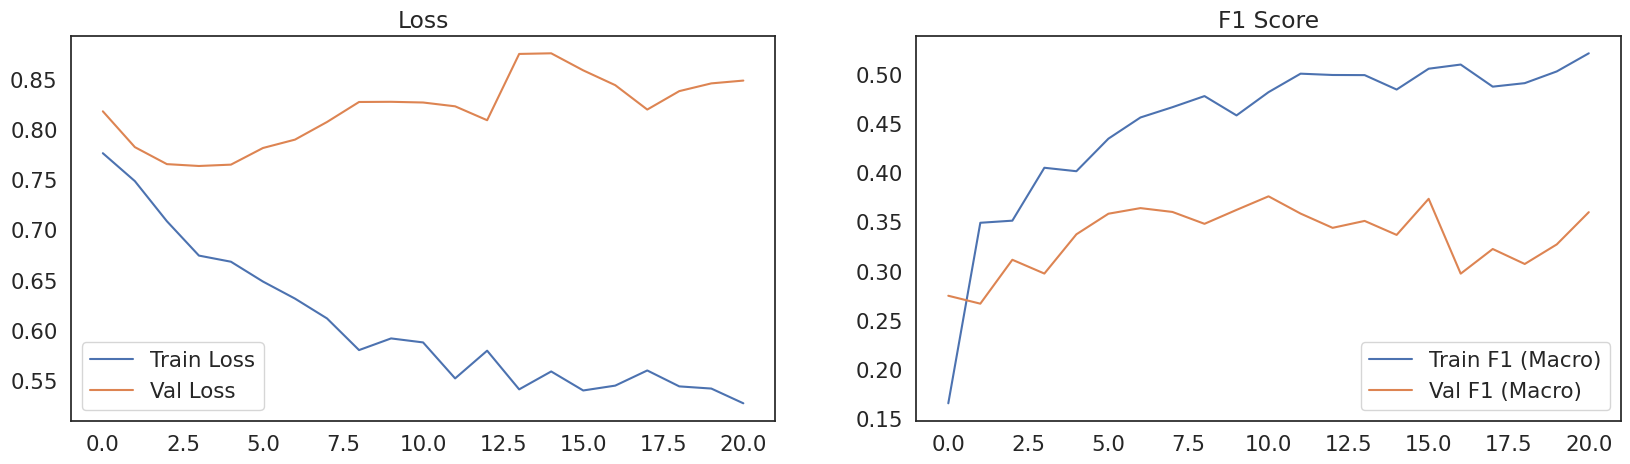

Best Validation F1 Score: 0.3761 at epoch 11


In [185]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.4 Confusion Matrix

Generating Confusion Matrix on Original Images...

Using masks from: ../an2dl2526c2/preprocessing_results/train_patches/masks

Aggregating predictions for 127 unique images...


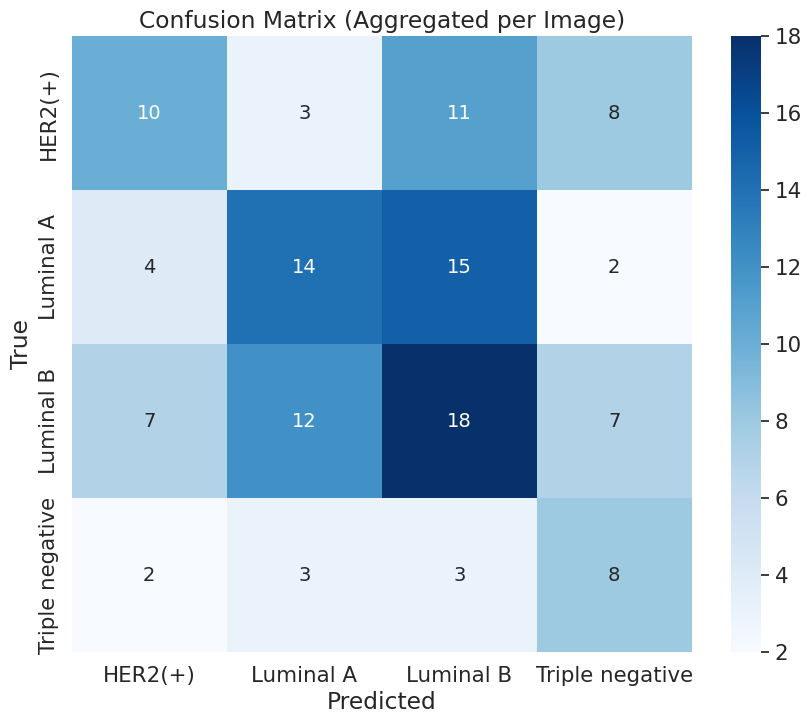

In [186]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()


Plotting random validation sample with prediction distribution:


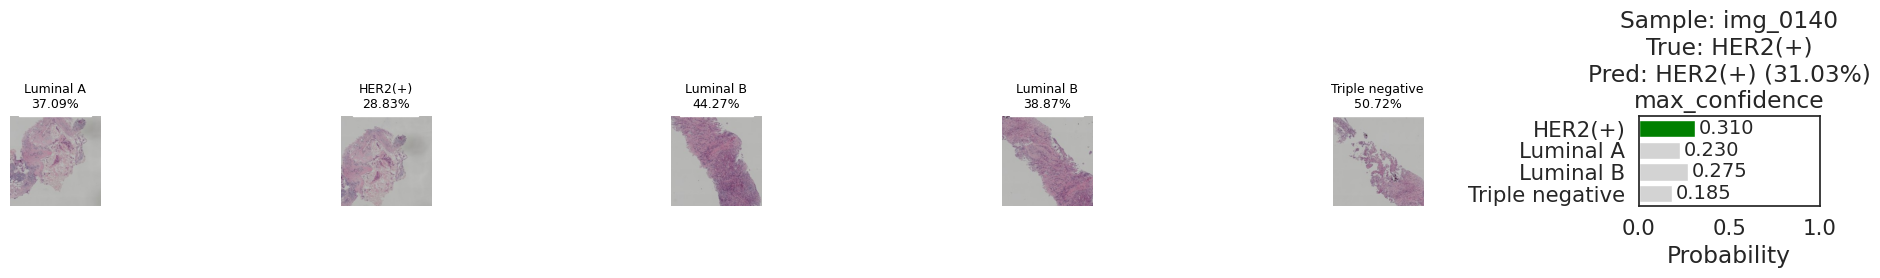

In [187]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence')

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [188]:
# 1. Initialize the NEW model instance
#    (Using the ResNet18 class we defined)
ft_model = RetCCLResNet50_MGAP(num_classes, DROPOUT_RATE, 
                          freeze_backbone=True,
                        ckpt_path=os.path.join("models","best_model_RetCCLResNet50_MGAP_tl.pt"),
                          unfreeze_last_block=True).to(device)


# Optimizer
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=1e-4,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)

# 5. New Scheduler
ft_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    ft_optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6
    
)



In [189]:
print_model_stats(ft_model)

Total params: 26,131,908
Trainable params: 17,326,340


In [190]:

print("Starting Fine-Tuning (ResNet18)")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1_ft = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
ft_better_than_tl = False

# Training Loop
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion, ft_optimizer, device)

    # Validate
    val_loss, val_f1 = validate(ft_model, val_loader, criterion, device)

    # Update Scheduler
    ft_scheduler.step(val_loss)

    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)

    # --- Checkpointing ---
    if val_f1 > best_val_f1_ft:
        best_val_f1_ft = val_f1
        best_ft_epoch = epoch + 1
        patience_counter_ft = 0 
        # UPDATED FILENAME: Changed from mobilenetv3 to resnet18
        torch.save(ft_model.state_dict(), 'models/best_model_RetCCLResNet50_MGAP_ft.pt')
        model_saved = True
        # Assuming best_val_f1 exists from previous TL phase
        if best_val_f1_ft > best_val_f1:
            ft_better_than_tl = True
    else:
        model_saved = False
        patience_counter_ft += 1

    # Logging
    status_mark = "✓" if model_saved else ""
    print(f"FT Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} {status_mark}")

    if patience_counter_ft >= PATIENCE:
        print("Early Stopping Triggered! Best FT Epoch: {} with Val F1: {:.4f}".format(best_ft_epoch, best_val_f1_ft))
        break

Starting Fine-Tuning (ResNet18)


FT Epoch 1/100 | Loss: 0.7773 | F1: 0.1113 | Val Loss: 0.8282 | Val F1: 0.1051 | Patience: 0/10 ✓


FT Epoch 2/100 | Loss: 0.7746 | F1: 0.1573 | Val Loss: 0.8256 | Val F1: 0.1859 | Patience: 0/10 ✓


FT Epoch 3/100 | Loss: 0.7740 | F1: 0.2349 | Val Loss: 0.8190 | Val F1: 0.2418 | Patience: 0/10 ✓


FT Epoch 4/100 | Loss: 0.7526 | F1: 0.2962 | Val Loss: 0.8005 | Val F1: 0.2542 | Patience: 0/10 ✓


FT Epoch 5/100 | Loss: 0.6927 | F1: 0.3331 | Val Loss: 0.7783 | Val F1: 0.3073 | Patience: 0/10 ✓


FT Epoch 6/100 | Loss: 0.6517 | F1: 0.3948 | Val Loss: 0.7552 | Val F1: 0.3487 | Patience: 0/10 ✓


FT Epoch 7/100 | Loss: 0.6090 | F1: 0.4554 | Val Loss: 0.8029 | Val F1: 0.3544 | Patience: 0/10 ✓


FT Epoch 8/100 | Loss: 0.5824 | F1: 0.4676 | Val Loss: 0.8376 | Val F1: 0.3816 | Patience: 0/10 ✓


FT Epoch 9/100 | Loss: 0.5271 | F1: 0.5353 | Val Loss: 0.7671 | Val F1: 0.3685 | Patience: 1/10 


FT Epoch 10/100 | Loss: 0.4910 | F1: 0.5526 | Val Loss: 0.8902 | Val F1: 0.3621 | Patience: 2/10 


FT Epoch 11/100 | Loss: 0.4572 | F1: 0.5695 | Val Loss: 0.8663 | Val F1: 0.4056 | Patience: 0/10 ✓


FT Epoch 12/100 | Loss: 0.4464 | F1: 0.6130 | Val Loss: 0.9884 | Val F1: 0.3771 | Patience: 1/10 


FT Epoch 13/100 | Loss: 0.4020 | F1: 0.6150 | Val Loss: 0.9377 | Val F1: 0.3890 | Patience: 2/10 


FT Epoch 14/100 | Loss: 0.3686 | F1: 0.6599 | Val Loss: 1.0155 | Val F1: 0.4147 | Patience: 0/10 ✓


FT Epoch 15/100 | Loss: 0.3413 | F1: 0.6846 | Val Loss: 1.0370 | Val F1: 0.3620 | Patience: 1/10 


FT Epoch 16/100 | Loss: 0.3159 | F1: 0.7088 | Val Loss: 1.1279 | Val F1: 0.3755 | Patience: 2/10 


FT Epoch 17/100 | Loss: 0.2963 | F1: 0.7090 | Val Loss: 1.2135 | Val F1: 0.3915 | Patience: 3/10 


FT Epoch 18/100 | Loss: 0.2884 | F1: 0.7408 | Val Loss: 1.0944 | Val F1: 0.4116 | Patience: 4/10 


FT Epoch 19/100 | Loss: 0.2607 | F1: 0.7547 | Val Loss: 1.1826 | Val F1: 0.4216 | Patience: 0/10 ✓


FT Epoch 20/100 | Loss: 0.2488 | F1: 0.7573 | Val Loss: 1.1549 | Val F1: 0.3852 | Patience: 1/10 


FT Epoch 21/100 | Loss: 0.2136 | F1: 0.7952 | Val Loss: 1.3525 | Val F1: 0.4007 | Patience: 2/10 


FT Epoch 22/100 | Loss: 0.2114 | F1: 0.7974 | Val Loss: 1.1807 | Val F1: 0.4277 | Patience: 0/10 ✓


FT Epoch 23/100 | Loss: 0.2190 | F1: 0.7904 | Val Loss: 1.2777 | Val F1: 0.4012 | Patience: 1/10 


FT Epoch 24/100 | Loss: 0.2214 | F1: 0.7847 | Val Loss: 1.2404 | Val F1: 0.4102 | Patience: 2/10 


FT Epoch 25/100 | Loss: 0.2049 | F1: 0.8120 | Val Loss: 1.2675 | Val F1: 0.4065 | Patience: 3/10 


FT Epoch 26/100 | Loss: 0.1737 | F1: 0.8309 | Val Loss: 1.3505 | Val F1: 0.3897 | Patience: 4/10 


FT Epoch 27/100 | Loss: 0.1595 | F1: 0.8485 | Val Loss: 1.5161 | Val F1: 0.3952 | Patience: 5/10 


FT Epoch 28/100 | Loss: 0.1712 | F1: 0.8446 | Val Loss: 1.3048 | Val F1: 0.4155 | Patience: 6/10 


FT Epoch 29/100 | Loss: 0.1742 | F1: 0.8323 | Val Loss: 1.3517 | Val F1: 0.3946 | Patience: 7/10 


FT Epoch 30/100 | Loss: 0.1680 | F1: 0.8399 | Val Loss: 1.2676 | Val F1: 0.4022 | Patience: 8/10 


FT Epoch 31/100 | Loss: 0.1452 | F1: 0.8621 | Val Loss: 1.3894 | Val F1: 0.4060 | Patience: 9/10 


FT Epoch 32/100 | Loss: 0.1567 | F1: 0.8568 | Val Loss: 1.3751 | Val F1: 0.4031 | Patience: 10/10 
Early Stopping Triggered! Best FT Epoch: 22 with Val F1: 0.4277


In [191]:
if ft_better_than_tl:
    print("Fine-Tuning improved over Transfer Learning. Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1_ft, best_ft_epoch))
    SUB_MODEL = 'models/best_model_RetCCLResNet50_MGAP_ft.pt'
else:
    print("Fine-Tuning did not improve over Transfer Learning. Best Validation F1 Score remains: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))
    SUB_MODEL = 'models/best_model_RetCCLResNet50_MGAP_tl.pt'

Fine-Tuning improved over Transfer Learning. Best Validation F1 Score: 0.4277 at epoch 22


### 13.2 Training History

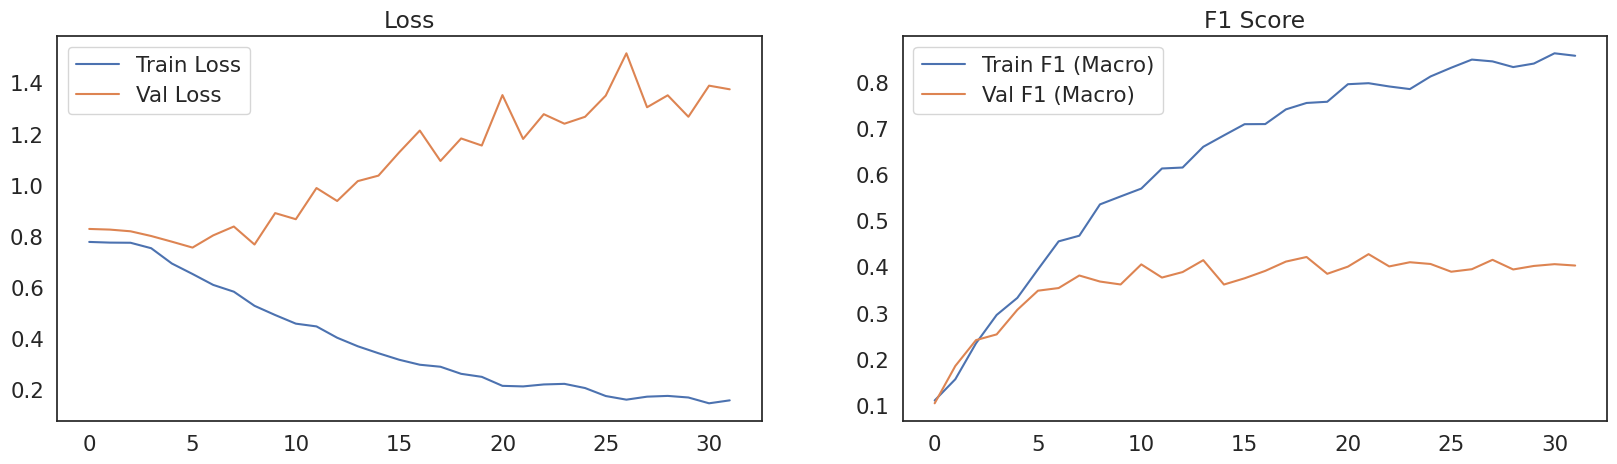

Best Fine-Tuned Validation F1 Score: 0.3761 at epoch 22


In [192]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

Generating Confusion Matrix for Transfer Learning Model...

Using masks from: ../an2dl2526c2/preprocessing_results/train_patches/masks

Aggregating predictions for 127 unique images...


Generating Confusion Matrix for Fine-Tuning Model...

Using masks from: ../an2dl2526c2/preprocessing_results/train_patches/masks

Aggregating predictions for 127 unique images...


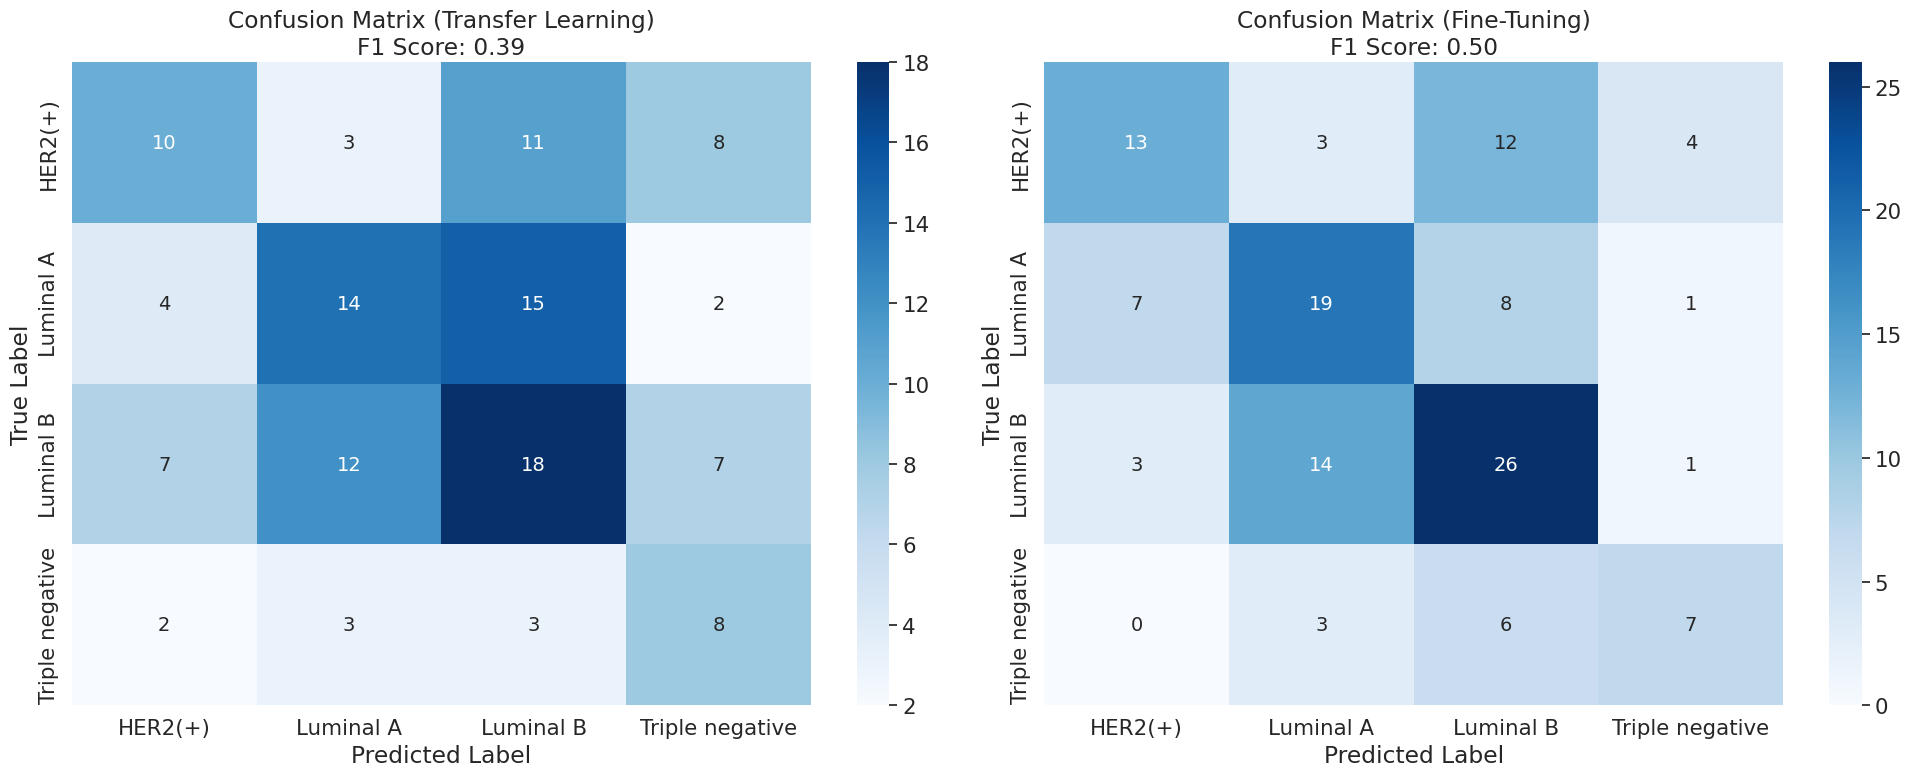

In [193]:

# 1. Get predictions for the Transfer Learning model (from original `model`)
print("Generating Confusion Matrix for Transfer Learning Model...")
y_true_tl, y_pred_tl = get_image_predictions(model, val_loader, device)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
f1_tl = f1_score(y_true_tl, y_pred_tl, average='macro')
# 2. Get predictions for the Fine-Tuning model (from `ft_model`)
print("Generating Confusion Matrix for Fine-Tuning Model...")
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)
f1_ft = f1_score(y_true_ft, y_pred_ft, average='macro')
# 3. Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'Confusion Matrix (Transfer Learning)\nF1 Score: {f1_tl:.2f}')

# Plot Fine-Tuning Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'Confusion Matrix (Fine-Tuning)\nF1 Score: {f1_ft:.2f}')

plt.tight_layout()
plt.show()


Transfer Learning:


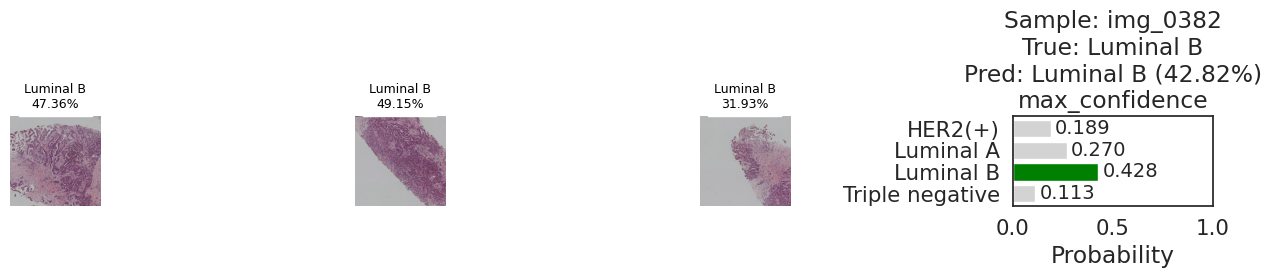

Fine Tuning:


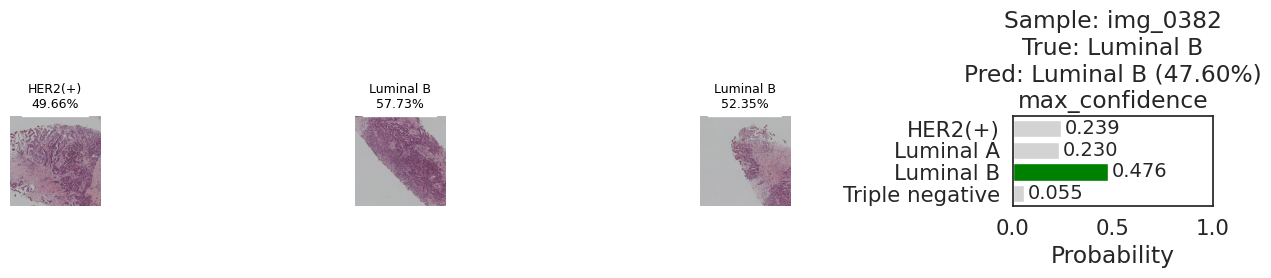

In [194]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [195]:
sub_model = RetCCLResNet50_MGAP(num_classes, DROPOUT_RATE,ckpt_path=SUB_MODEL, freeze_backbone=True).to(device)

sub_model.load_state_dict(torch.load(SUB_MODEL), strict=True)

print(f"Submodel {SUB_MODEL} loaded for inference.")

Submodel models/best_model_RetCCLResNet50_MGAP_ft.pt loaded for inference.


### 14.2 Define Transform

In [196]:
# Define Validation Transform (Compatible with V2 or Standard)
val_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(), # Robust standard equivalent to ToImage + ToDtype
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


### 14.3 Function: Submission CSV

In [197]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

def generate_submission(model, submission_folder, masks_folder=None, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file for the Two-Stream (Two Pillar) model.
    Args:
        model: Trained TwoStream/ResNetParallel model.
        submission_folder: Folder containing test patch images.
        masks_folder: (Optional) Folder containing corresponding masks. 
                      If None, tries to find them or uses black masks.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    if masks_folder:
        print(f"Looking for masks in: {masks_folder}")
    else:
        print("No mask folder provided. Using black masks (or inferred paths).")

    # 2. Define Transforms
    # Image: Normalize
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Mask: No Normalize
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Store predictions per image
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # Extract Sample ID
                if '_p' in filename:
                    sample_id = filename.rsplit('_p', 1)[0]
                else:
                    sample_id = os.path.splitext(filename)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # --- A. Load Image ---
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # --- B. Load Mask ---
                # Default: Black mask
                mask_pil = Image.new('L', (224, 224), 0)
                
                if masks_folder:
                    # Construct mask filename (e.g., img_X.png -> mask_X.png)
                    mask_filename = filename.replace('img_', 'mask_')
                    mask_path = os.path.join(masks_folder, mask_filename)
                    
                    if os.path.exists(mask_path):
                        mask_pil = Image.open(mask_path).convert('L')
                
                mask_tensor = mask_transform(mask_pil).unsqueeze(0).to(device)

                # --- C. Model Inference (Two Pillars) ---
                # Pass BOTH tensors
                logits = model(input_tensor, mask_tensor)
                
                # Softmax to get probabilities
                probs = torch.softmax(logits, dim=1)

                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                # print(f"Error processing {filename}: {e}")
                pass

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) 

        # Reconstruct full filename for submission (e.g. img_0015.png)
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) 
            continue

        if method == 'majority_voting':
            patch_preds = np.argmax(all_probs, axis=1)
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Save
    df_submission = pd.DataFrame(final_results)
    
    if 'sample_index' in df_submission.columns:
        df_submission.sort_values('sample_index', inplace=True)
    
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    # print(df_submission.head())

    return df_submission

### 14.3 Create the Submission CSV

In [198]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:


now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")

SUB_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results", "submission_patches", "masks")
os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME, masks_folder=SUB_MASKS_DIR)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

Found 2301 patches in ../an2dl2526c2/preprocessing_results/submission_patches
Looking for masks in: ../an2dl2526c2/preprocessing_results/submission_patches/masks
Running inference...


100%|██████████| 2301/2301 [00:24<00:00, 94.31it/s] 

Aggregating results for 477 unique samples...
Submission saved to ../submission_csvs/submission_ft--13_Dec-15_16.csv
Submission CSV saved to: ../submission_csvs/submission_ft--13_Dec-15_16.csv
